# Time series data 
See <a href="https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series">Linear Regression With Time Series</a> for original notebook.


Time series (TS) analysis is a specific way of analyzing a sequence of data points collected over an interval of time (like daily, or monthly).  Much of the worlds data is in this format, examples include; daily store sales, daily temp, sunspot activity, tunnel traffic.  This data can broadly be described as;

`univariate TS data`: a series of observations, each consisting of a time and observed value. Example (time, temp)<br>
`multivariate TS data`: a series of observations, each consisting of a time and MULTIPLE observed values. Example (time,temp, humidity, sunindex)

A common data science task is to use this time series data to predict future events. We will start with a simple predictive model for a <mark>univariate time series 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

plt.style.use('default')

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [2]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))

df.head()

,NumVehicles,Time
Date,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


## See what it looks like

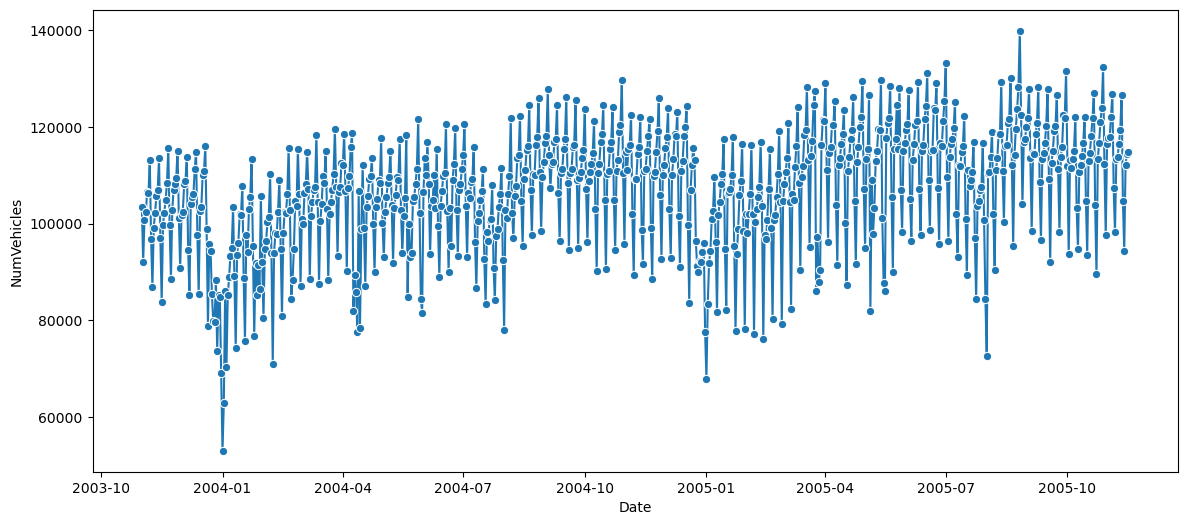

In [3]:
#lets see what it looks like
# sns.scatterplot(x=df.Day, y=df.NumVehicles) #yikes, thats a bit hard to read
fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(x=df.index, y=df.NumVehicles,ax=ax1,  marker="o")

## It looks like it cycles between high and low values which doesnt make sense for a tunnel. Shouldn't it be consistant?
Lets examine a smaller slice to get some notion about why

In [4]:
#get the first 100 rows
df1=df.iloc[:100,:]

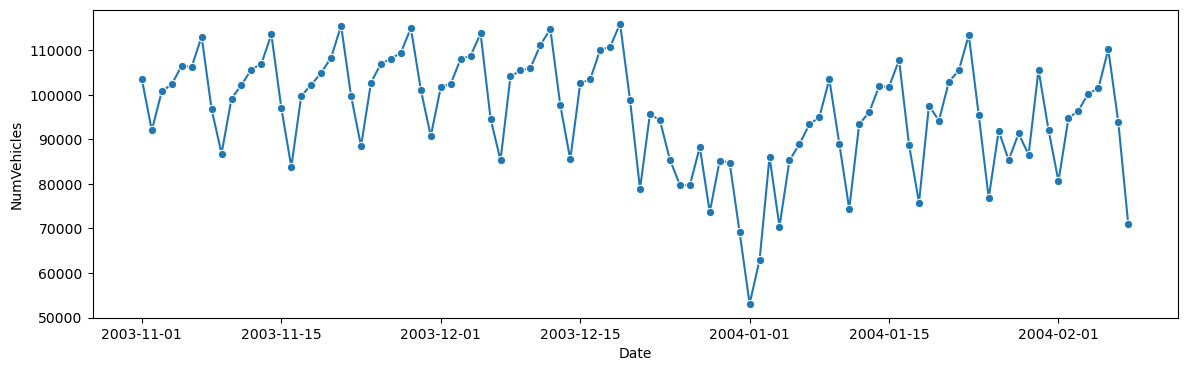

In [5]:
#and lets see them
fig, ax1 = plt.subplots(figsize=(14,4))
_=sns.lineplot(x=df1.index, y='NumVehicles', data=df1,ax=ax1,  marker="o")

### <mark> The cycling represents travel that peaks during the week, and drops on the weekend

##  Lets see what the average number of cars are per day of the week to confirm this

In [6]:
#convert the index to datetime and get the days of the week and add to the dataframe
df['dayofweek'] = pd.to_datetime(df.index).day_name()
df.head()

,NumVehicles,Time,dayofweek
Date,,,
2003-11-01,103536,0,Saturday
2003-11-02,92051,1,Sunday
2003-11-03,100795,2,Monday
2003-11-04,102352,3,Tuesday
2003-11-05,106569,4,Wednesday


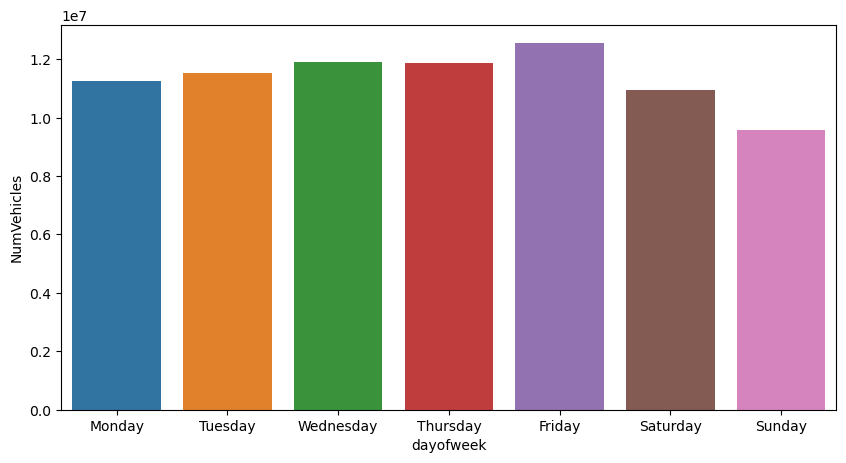

In [7]:
plt.figure(figsize=(10, 5))
dfgb=df.groupby(by='dayofweek').sum()

#argh they are not in chrono order! fix it
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dfgb = dfgb.reindex(cats)

sns.barplot(data=dfgb,x=dfgb.index,y='NumVehicles' );

In [8]:
df.drop(columns=['dayofweek'], inplace=True)  #no longer needed

## OK enough playing in traffic, the data clearly has a trend to it (up) lets capture it using linear regression

In this case we have Time as the independant variable and NumVehicles as the dependant variable.  The equation for linear regression is:
```
NumVehicles=weight1*Time + bias
```
The model will learn values for weight1 and bias so that the above equation fits the data as well as possible.  Another way of stateing this is that it learns values that reduce the residuals (the difference between the actual and predicted) by as much as possible. 


In [10]:
from sklearn import linear_model
def train_model(X,y):
    '''
    X: train on this, for this notebook its 1 column of data
    y: the target
    return: the trained model
    '''
    reg = linear_model.LinearRegression()
    reg.fit(X=X, y=y)
    return reg

mod1=train_model(df.Time.values.reshape(-1,1), df.NumVehicles)
preds=mod1.predict(df.Time.values.reshape(-1,1))

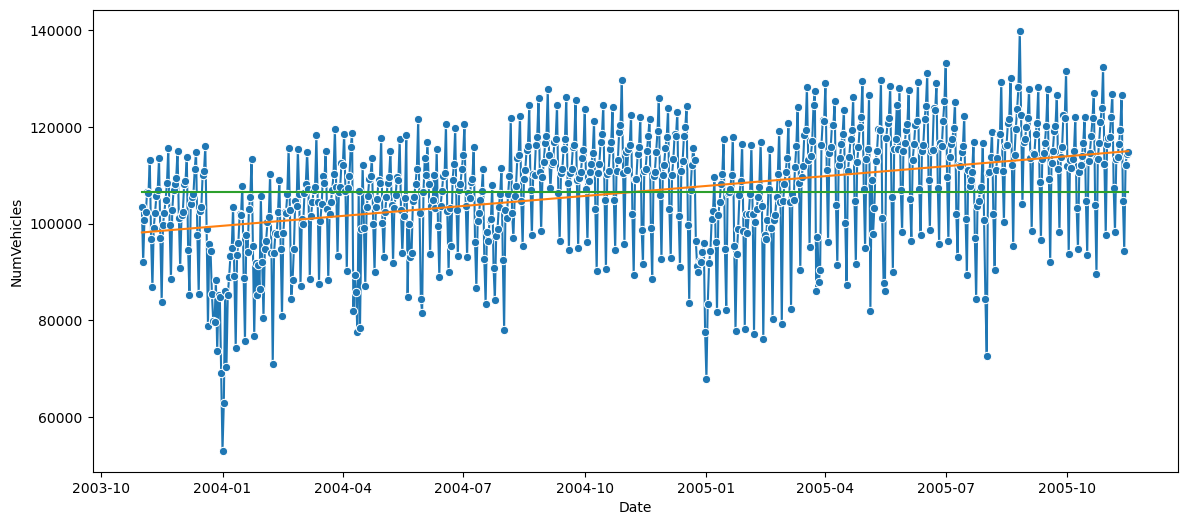

In [11]:
def show_preds(x_axis, target, preds):
    '''
    plot both the target and the preds against the x_axis
    plot the average of the preds as well
    '''
    av=preds.sum()/len(preds)
    fig, ax1 = plt.subplots(figsize=(14,6))
    _=sns.lineplot(x=x_axis, y=target,ax=ax1,  marker="o")
    _=sns.lineplot(x=x_axis, y=preds,ax=ax1)
    _=sns.lineplot(x=x_axis, y=av,ax=ax1)
show_preds(df.index, df.NumVehicles, preds)

## Its just captures the trend

In [41]:
a=1
b=2

s=f'{a}'
s=s+f' {b}'

for a,b in zip([111,222],['defg','hi']):
    print(f'{a} {b}')
s

111 defg
222 hi


'1 2'

In [43]:
def show_regression_formula(mod, target, independant_var, show_explanation=True):
    '''
    mod: the trained linear regression model
    target: string, the name of the dependant variable(s)
    independant_var: string, the name of the independant variable
    '''
    #what are the linear regression parameters for w1 and bias?
    if(show_explanation==True):
        print('Linear regression formula is:')
    
    s=f'{target}='
    for coef, ind_var in zip(mod.coef_,independant_var) :
        s=s+f'{coef:.3f}*{ind_var}'
    print(s +f' +{mod.intercept_:.3f}')
show_regression_formula(mod2,'NumVehicles',['df.Time'])

Linear regression formula is:
NumVehicles=0.533*df.Time +49780.625


<mark> NOTE that we are multiplying the weight (22.497) by df.Time which is just an ascending integer(1,2,3...).<br>  This line will have an intercept at ~98176 and will rise uniformly. Its is a STRAIGHT line because df.Time is uniformly increasing.!

### Lags

What if instead of using df.Time as the independant variable for Linear regression, we use the last known value for the predicted variable (NumVehicles-1)? This requires that we create a new feature. Since it lags by 1 time step call it Lag_1.

This type of feature is called a `lag`.  A lag provides your model with information about the targets value in the past.  A lag can be set to the last value (y-1), or any value n timesteps previous (y-n).  You can additionally create multiple lags to give your model more data to predict on (Lag_1, Lag_2, Lag_3) etc. There is no cheating here, the model is simply using past and known target values to help predict future values.<br>
Pandas provides a simple method to lag a series, the `shift` method.  Notice that the Lag_1 column contains the value in the previous rows NumVehicles column.  This way each row has the current NumVehicles and the last value of NumVehicles (Lag_1).  The model can use this lag to help predict since the current value of NumVehicles is likely to be near Lag_1 (NumVehicles-1).

In [13]:
df['Lag_1'] = df['NumVehicles'].shift(1)
# df['Lag_2'] = df['NumVehicles'].shift(2)  #another lag thats shifted back 2
df.head()

,NumVehicles,Time,Lag_1
Date,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [14]:
#what to do about that first rows NaN?  We could set it to first known value.  Or just drop it
df.dropna(inplace=True)
# df.head()

In [15]:
#refit the model on the lag
mod2=train_model(df.Lag_1.values.reshape(-1,1),df.NumVehicles)
preds=mod2.predict(df.Lag_1.values.reshape(-1,1))

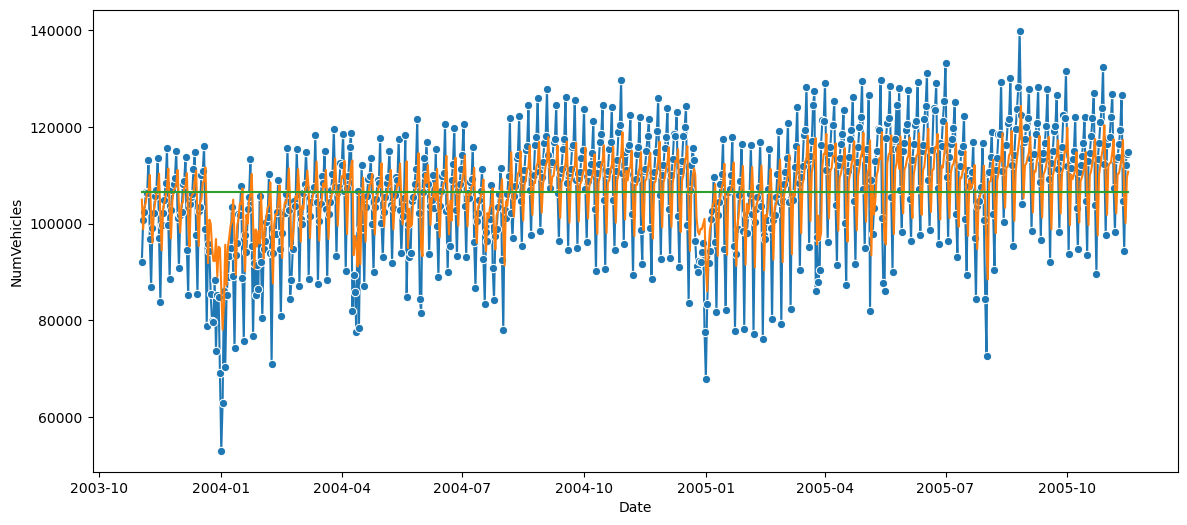

In [16]:
show_preds(df.index, df.NumVehicles, preds)

## <MARK>WHAT! WHERE IS THE LINEAR LINE?

In [17]:
#Its there
show_regression_formula(mod2,'NumVehicles','df.Lag_1', show_explanation= False)

NumVehicles=0.533*df.Lag_1 +49780.625


It's still a linear equation.  The reason its not linear when plotted is because we are multiplying .533 times the Lag_1 value.  The Lag_1 value is going to track what the original data in blue above does, so it's all over the place.

## <mark>Can we agree that using lags makes for a better prediction than using a plain jane time step?

### Confirm visual conclusion by scoring model

In [18]:
from objectives import scoremodel

#score the model that just uses time
scoremodel(mod1,df.Time.values.reshape(-1,1),df.NumVehicles )

Score on test setusing models score function: 0.15
Score on test set using rsquared: 0.15


In [20]:
#and now score the model that uses the lags
scoremodel(mod2,df.Lag_1.values.reshape(-1,1),df.NumVehicles )
# mod.score(df.Lag_1.values.reshape(-1,1),df.NumVehicles)

Score on test setusing models score function: 0.28
Score on test set using rsquared: 0.28


## <mark>Usually (unless the model is garbage),  0<=R squared<=1.  The closer to 1 the better.  So the second model using lags is better than the first

## <mark>What if we use more lags?  Does it get better?

In [49]:
#what if we use more lags?
df['Lag_2'] = df['NumVehicles'].shift(2)
df.dropna(inplace=True)
df.head()

,NumVehicles,Time,Lag_1,Lag_2
Date,,,,
2003-11-08,96806,7,113111.0,106284.0
2003-11-09,86811,8,96806.0,113111.0
2003-11-10,99194,9,86811.0,96806.0
2003-11-11,102253,10,99194.0,86811.0
2003-11-12,105707,11,102253.0,99194.0


In [54]:
mod3=train_model(df.loc[:,['Lag_1','Lag_2']],df.NumVehicles)
preds=mod3.predict(df.loc[:,['Lag_1','Lag_2']])

In [56]:
scoremodel(mod3,df.loc[:,['Lag_1','Lag_2']],df.NumVehicles )

Score on test setusing models score function: 0.30
Score on test set using rsquared: 0.30


### Yes it does, but it seems to be asymptotic to some value

In [57]:
 # print(f'{target}={mod.coef_[0]:.3f}*{independant_var} +{mod.intercept_:.3f}')
show_regression_formula(mod3,'NumVehicles',['Lag_1','Lag_2'])

Linear regression formula is:
NumVehicles=0.605*Lag_1-0.136*Lag_2 +56581.605


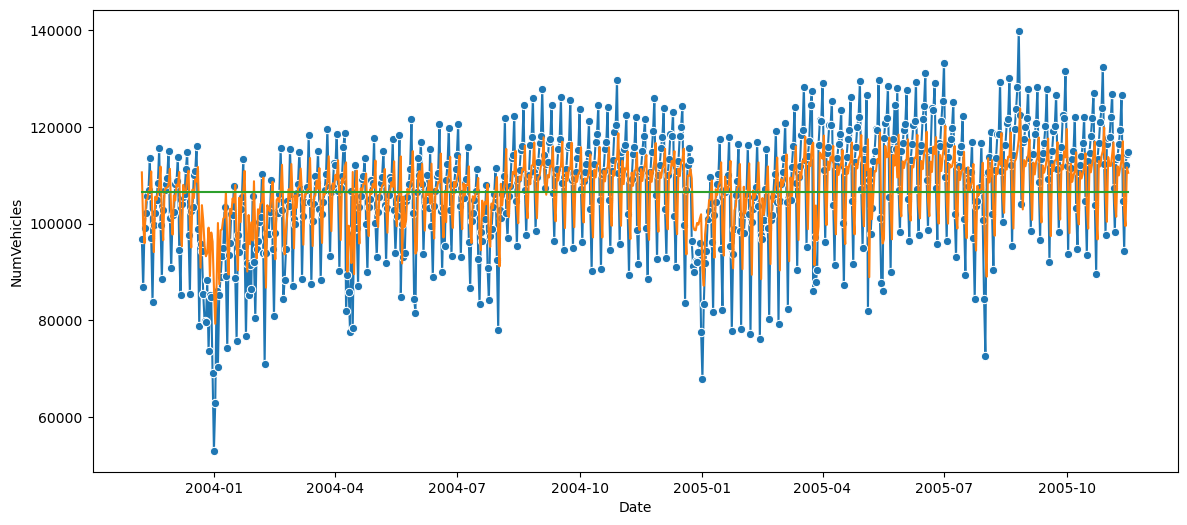

In [59]:
show_preds(df.index, df.NumVehicles, preds)